In [1]:
import numpy as np
import math

from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
class Unitary2(object):
    """
    Create a 2x2 unitary matrix from three angles, specify in radians.

    We'll use the decomposition shown in wikipedia.
    U = exp(i*phi) * m3 @ m2 @ m1, where
    m3 = [[exp(i*psi), 0], [0, exp(-i*psi)]]
    m2 = [[cos(theta), sin(theta)], [-sin(theta), cos(theta)]]
    m1 = [[exp(i*delta), 0], [0, exp(-i*delta)]]
    """
    def __init__(self, psi, theta, delta, phi=0.0) -> None:
        self._psi = psi
        self._theta = theta
        self._delta = delta
        self._phi = phi
        self._build_matrix()

    def _build_matrix(self):
        exp_psi = np.exp(1j * self.psi)
        c = np.cos(self.theta)
        s = np.sin(self.theta)
        exp_delta = np.exp(1j * self.delta)

        m1 = np.array([[exp_delta, 0.0], [0.0, np.conj(exp_delta)]])
        m2 = np.array([[c, s], [-s, c]])
        m3 = np.array([[exp_psi, 0.0], [0.0, np.conj(exp_psi)]])

        self.matrix = np.exp(1j * self.phi) * m3 @ m2 @ m1
        self._is_unitary()

    # Below allow us to change the settings of the unitary, and
    # rebuild the matrix.
    @property
    def psi(self):
        return self._psi

    @psi.setter
    def psi(self, val):
        self._psi = val
        self._build_matrix()

    @property
    def theta(self):
        return self._theta

    @theta.setter
    def theta(self, val):
        self._theta = val
        self._build_matrix()

    @property
    def delta(self):
        return self._delta

    @delta.setter
    def delta(self, val):
        self._delta = val
        self._build_matrix()

    @property
    def phi(self):
        return self._phi

    @phi.setter
    def phi(self, val):
        self._phi = val
        self._build_matrix()

    ###

    def _is_unitary(self):
        # check that it's a unitary matrix
        assert np.allclose(self.matrix @ self.matrix.conj().T, np.identity(2))
        assert np.allclose(self.matrix.conj().T @ self.matrix, np.identity(2))

    def forward(self, x):
        return self.matrix @ x

    def backward(self, x):
        return self.matrix.T @ x

    def __repr__(self):
        return f"(ψ,δ,θ,φ) = ({self.psi/np.pi}, {self.delta/np.pi}, {self.theta/np.pi}, {self.phi/np.pi})*π\n" + \
            f"Matrix:\n{self.matrix}"

In [3]:
class MZI(Unitary2):
    def __init__(self, theta) -> None:
        super().__init__(psi=0.0, theta=theta, delta=0.0, phi=0.0)

    def _build_matrix(self):  # can only change theta in an MZI
        super()._build_matrix()
        assert(np.allclose([self.psi, self.delta, self.phi], np.zeros(3)))


class PhaseShifter(Unitary2):
    def __init__(self, phase) -> None:
        super().__init__(psi=phase, theta=0.0, delta=0.0, phi=0.0)

    def _build_matrix(self):  # can only change psi in a phase shifter
        super()._build_matrix()
        assert (np.allclose([self.theta, self.delta, self.phi], np.zeros(3)))

    @property
    def phase(self):
        return self._psi

    @phase.setter
    def phase(self, val):
        self.psi = val

class Fiber(Unitary2):
    """
    Creat a random 2x2 unitary that represents the fiber rotation
    """
    def __init__(self) -> None:
        rvals = np.random.default_rng().uniform(-np.pi, np.pi, 3)
        super().__init__(psi=rvals[0], theta=rvals[1], delta=rvals[2])

In [4]:
mzi_1 = MZI(theta=0.0)
ps_1 = PhaseShifter(0.0)

mzi_2 = MZI(theta=0.0)
ps_2 = PhaseShifter(0.0)

fiber_1 = Fiber()
fiber_2 = Fiber()

In [5]:
def objective_reverse(phases, input_state, params):
    """
    The objective function here is just maximize the received signal in the
    RX of port 2
    """
    phase_1 = phases[0]  # phase shifter setting
    theta_1 = phases[1]  # MZI setting
    phase_2 = phases[2]  # phase shifter setting
    theta_2 = phases[3]  # MZI setting

    ps_1.phase = phase_1
    mzi_1.theta = theta_1

    ps_2.phase = phase_2
    mzi_2.theta = theta_2

    output_state_reverse = mzi_1.matrix.T @ ps_1.matrix.T @ fiber_2.matrix.T @ fiber_1.matrix.T @ ps_2.matrix.T @ mzi_2.matrix.T @ input_state
    I_top_port = np.abs(output_state_reverse[0])**2
    I_bottom_port = np.abs(output_state_reverse[1])**2

    intensities = [I_top_port, I_bottom_port]
    curr_params = [phase_1, theta_1, phase_2, theta_2] + [output_state_reverse[0], output_state_reverse[1]] + intensities
    params.append(curr_params)

    return -1.0 * intensities[-1]  # maximize the receiving port power

In [6]:
input_state_reverse = np.array([1.0, 0.0])

bounds = [(-math.pi, math.pi), (-math.pi, math.pi), (-math.pi, math.pi), (-math.pi, math.pi)]

opts = {'fatol': 1e-6}
params = []
result = minimize(objective_reverse, (0.0, 0.0, 0.0, 0.0),
                  bounds=bounds,
                  args=(input_state_reverse, params),
                  method='Nelder-Mead',
                  options=opts)

/Users/sashwyn06/miniconda3/envs/lmphoton/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


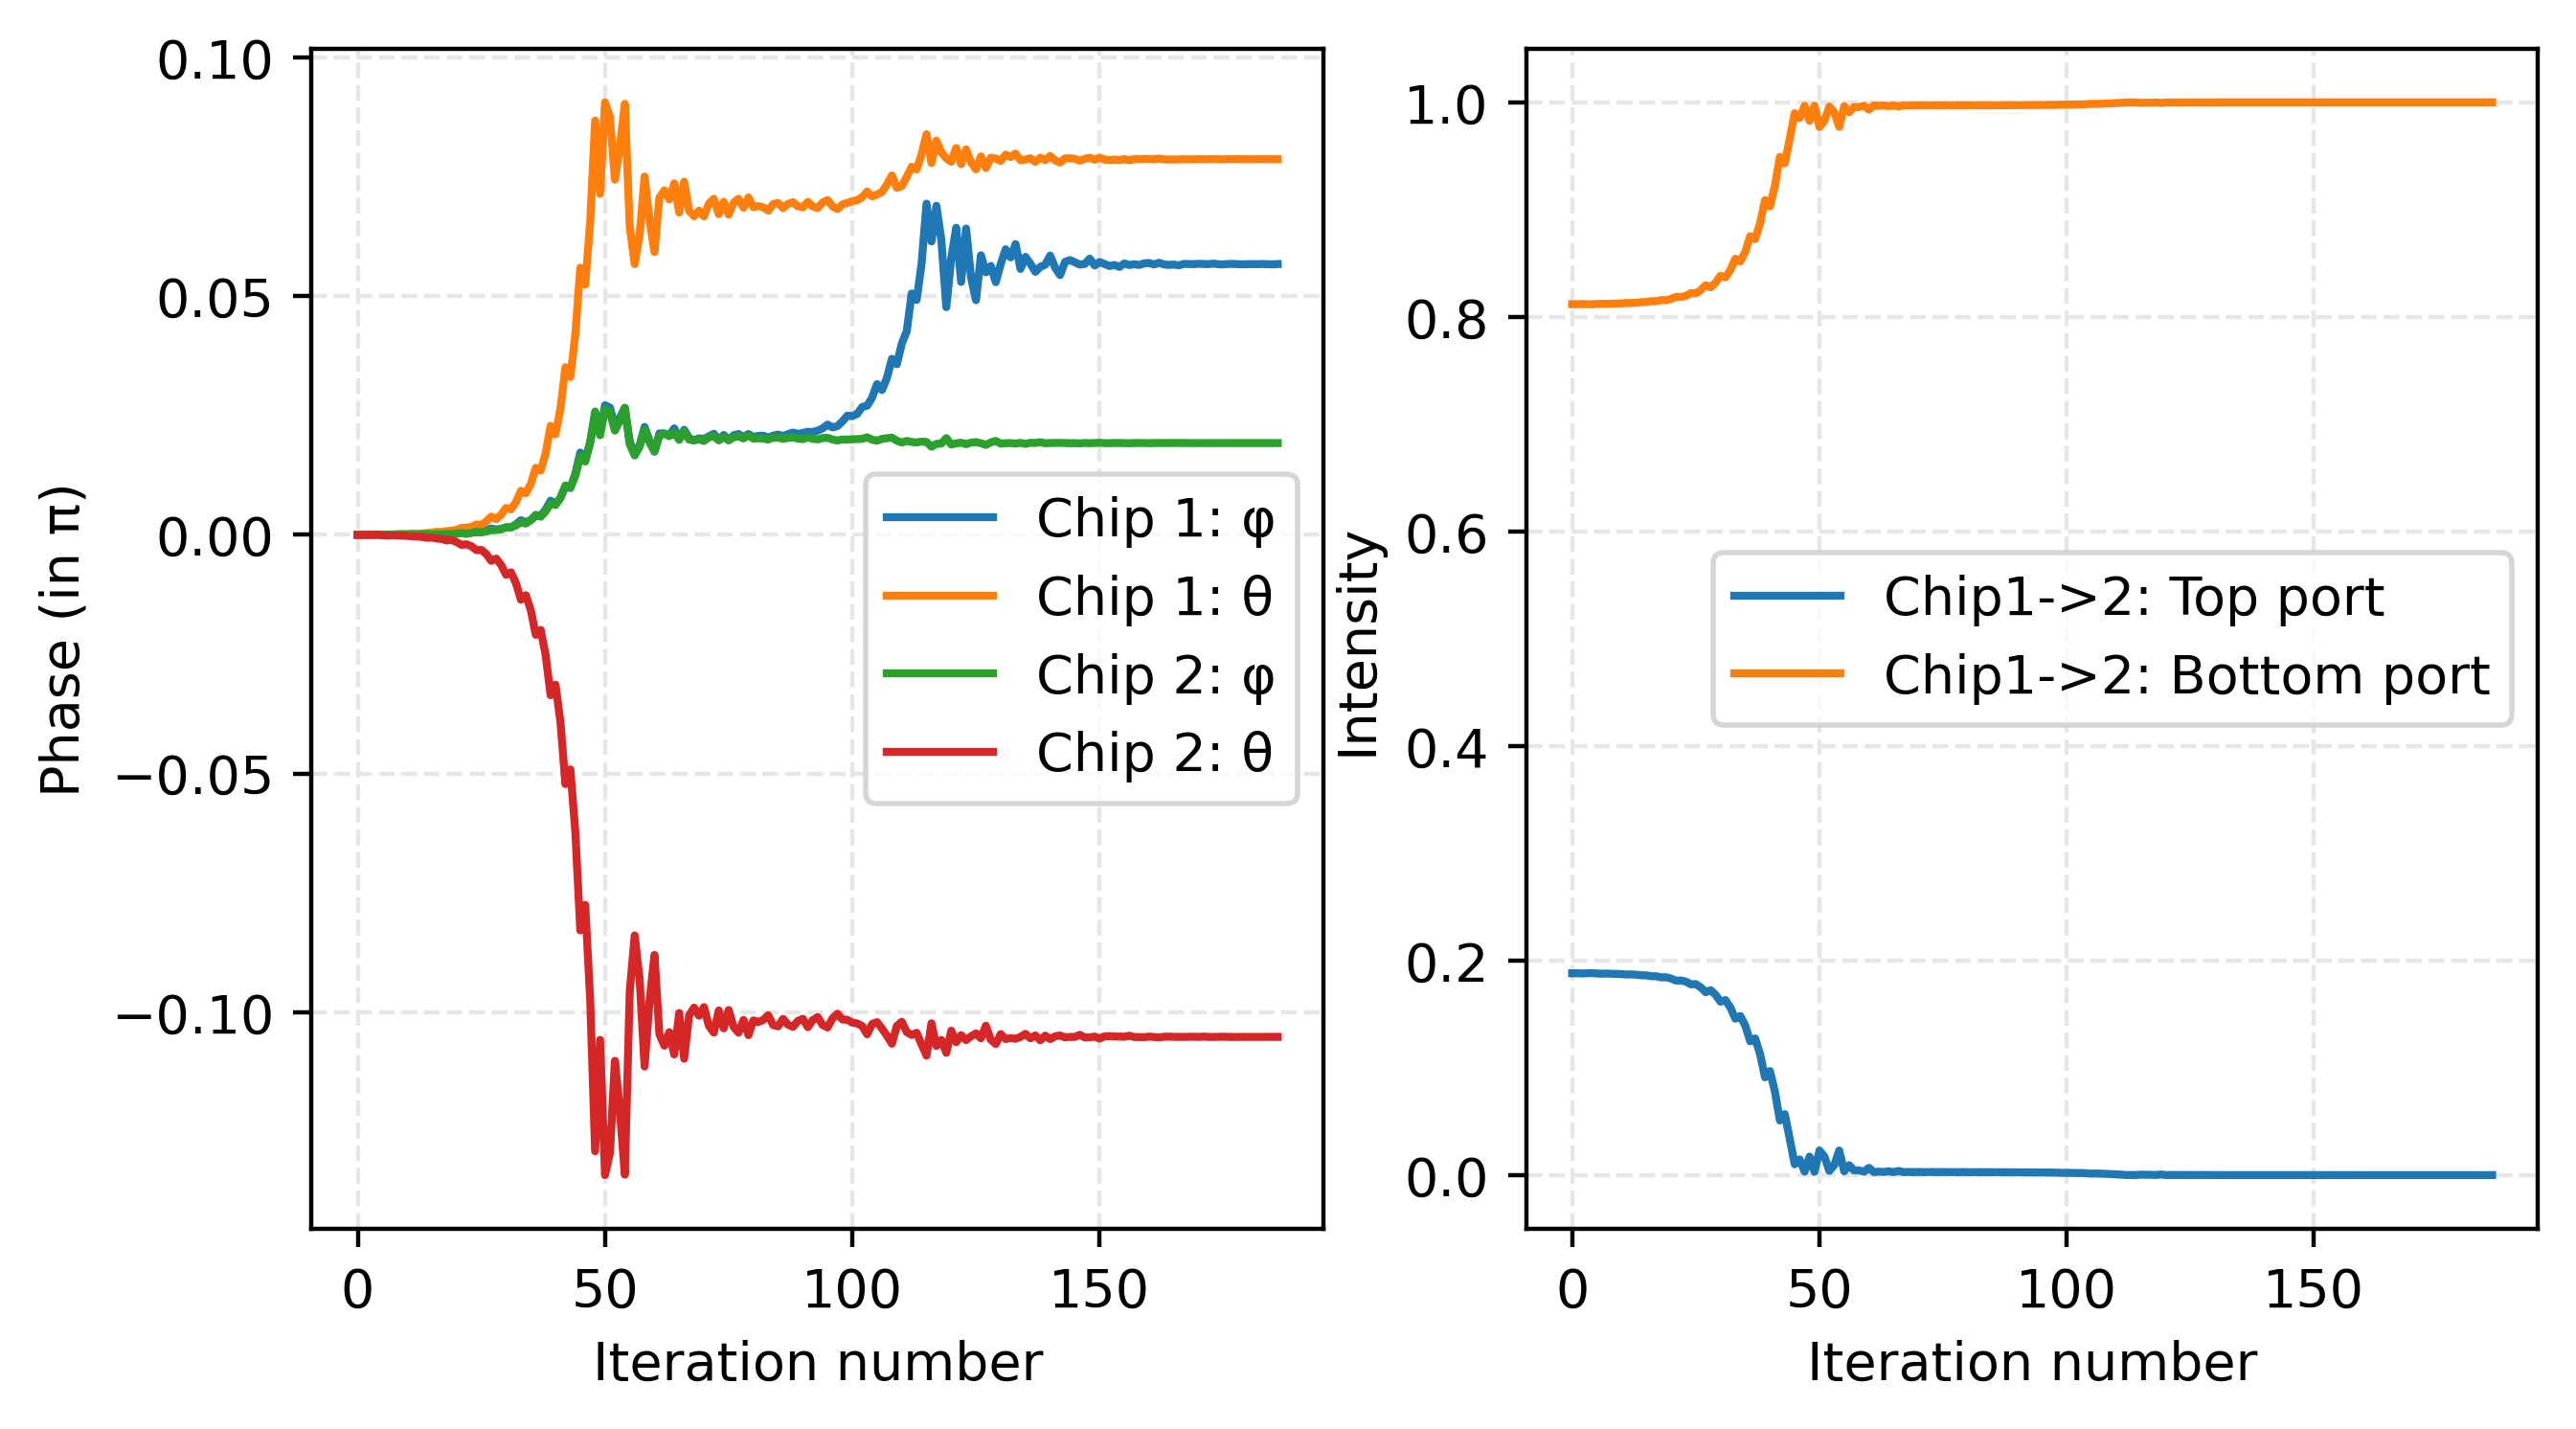

In [7]:

def plot_optimization(params):
    iters = np.arange(len(params))
    params = np.array(params)
    labels = ["Chip 1: φ", "Chip 1: θ", "Chip 2: φ", "Chip 2: θ"]
    plt.figure(figsize=(7.5, 4), dpi=400)
    plt.subplot(1, 2, 1)
    plt.plot(iters, params[:, 0:4]/np.pi, label=labels)
    plt.ylabel('Phase (in π)')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

    labels = [
        "Chip1->2: Top port",
        "Chip1->2: Bottom port"
    ]
    plt.subplot(1, 2, 2)
    plt.plot(iters, params[:, 6:], label=labels)
    plt.ylabel('Intensity')
    plt.xlabel('Iteration number')
    plt.legend()
    plt.grid(True, which="both", ls="dashed", color='.9')

plot_optimization(params)  

In [8]:
print("Fiber 1: \n", fiber_1)
print("Fiber 2: \n", fiber_2)

Fiber 1: 
 (ψ,δ,θ,φ) = (0.27870541510758495, 0.2613776015879665, -0.468759758014396, 0.0)*π
Matrix:
[[-0.01230633+0.09721077j -0.99371354-0.05414821j]
 [ 0.99371354-0.05414821j -0.01230633-0.09721077j]]
Fiber 2: 
 (ψ,δ,θ,φ) = (0.6487686903693715, -0.9401966078262995, -0.16860223496903992, 0.0)*π
Matrix:
[[ 0.52585563-0.68424513j -0.13938424+0.48565059j]
 [ 0.13938424+0.48565059j  0.52585563+0.68424513j]]


In [9]:
input_state_forward = np.array([1.0, 0.0])
output_state_forward = mzi_2.matrix @ ps_2.matrix @ fiber_1.matrix @ fiber_2.matrix @ ps_1.matrix @ mzi_1.matrix @ input_state_forward
connector_state_forward = fiber_2.matrix @ ps_1.matrix @ mzi_1.matrix @ input_state_forward
reflected_state_forward = mzi_1.matrix.T @ ps_1.matrix.T @ fiber_2.matrix.T @ connector_state_forward
print("Output state forward intensity: ", np.abs(output_state_forward)**2, ", state: ", output_state_forward)
print("Connector state forward intensity: ", np.abs(connector_state_forward)**2, ", state: ", connector_state_forward)
print("Reflected state forward intensity: ", np.abs(reflected_state_forward)**2, ", state: ", reflected_state_forward)

Output state forward intensity:  [3.93597867e-10 1.00000000e+00] , state:  [1.96045292e-05-3.04307445e-06j 6.15029588e-01-7.88504030e-01j]
Connector state forward intensity:  [0.86930671 0.13069329] , state:  [ 0.63192459-0.68554943j -0.10691812+0.34534303j]
Reflected state forward intensity:  [0.91597759 0.08402241] , state:  [-1.78479643e-01-0.94027794j -4.53851572e-17+0.28986619j]


In [10]:
input_state_reverse = np.array([1.0, 0.0])
output_state_reverse = mzi_1.matrix.T @ ps_1.matrix.T @ fiber_2.matrix.T @ fiber_1.matrix.T @ ps_2.matrix.T @ mzi_2.matrix.T @ input_state_reverse
connector_state_reverse = fiber_1.matrix.T @ ps_2.matrix.T @ mzi_2.matrix.T @ input_state_reverse
reflected_state_reverse = mzi_2.matrix @ ps_2.matrix @ fiber_1.matrix @ connector_state_reverse
print("Output state reverse intensity: ", np.abs(output_state_reverse)**2, ", state: ", output_state_reverse)
print("Connector state reverse intensity: ", np.abs(connector_state_reverse)**2, ", state: ", connector_state_reverse)
print("Reflected state reverse intensity: ", np.abs(reflected_state_reverse)**2, ", state: ", reflected_state_reverse)

Output state reverse intensity:  [3.93597867e-10 1.00000000e+00] , state:  [ 1.96045292e-05-3.04307445e-06j -6.15029588e-01-7.88504030e-01j]
Connector state reverse intensity:  [0.13068645 0.86931355] , state:  [-0.3380477 +0.12810232j -0.92921396-0.07664835j]
Reflected state reverse intensity:  [0.91596348 0.08403652] , state:  [9.55429649e-01+0.05583605j 1.01696043e-17+0.28989054j]


In [11]:
print("Dot products:")
print("Input: ", np.vdot(input_state_forward, input_state_reverse))
print("Forward: ", np.vdot(output_state_forward, output_state_reverse))
print("Connector: ", np.vdot(connector_state_forward, connector_state_reverse))
print("Reflected: ", np.vdot(reflected_state_forward, reflected_state_reverse))

Dot products:
Input:  1.0
Forward:  (0.24347721238332273-0.969906617388764j)
Connector:  (-0.22856129440241224+0.1782952583514487j)
Reflected:  (-0.1389966817855107+0.8884038273195249j)
